In [ ]:
%pip install git+https://github.com/openai/CLIP.git

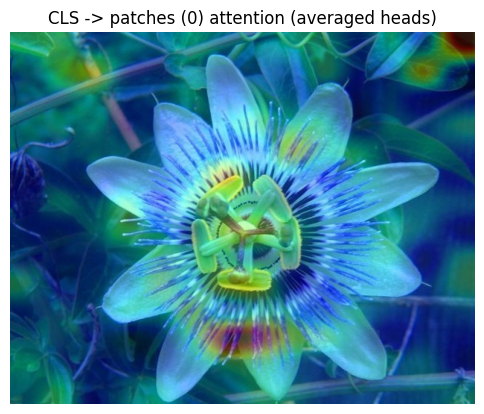

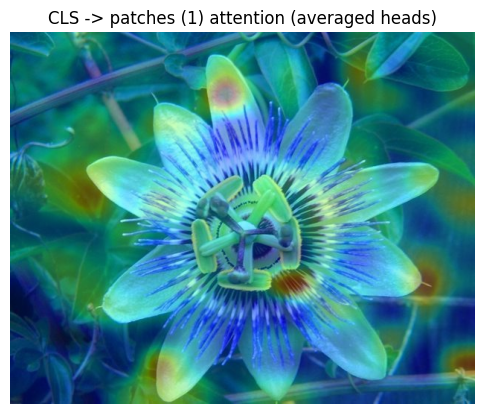

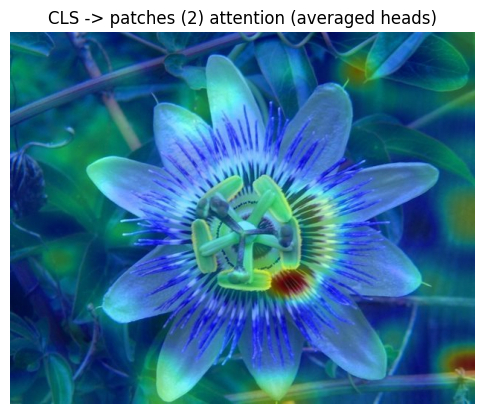

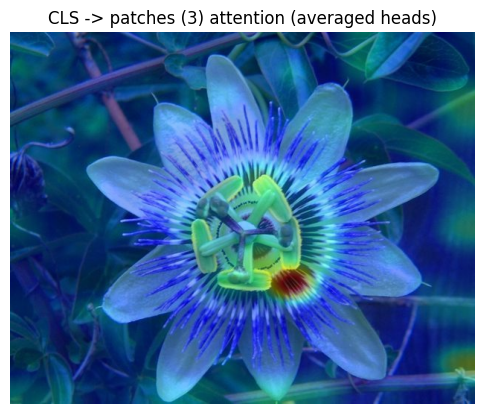

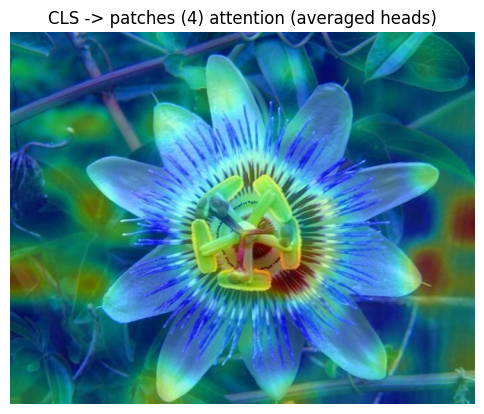

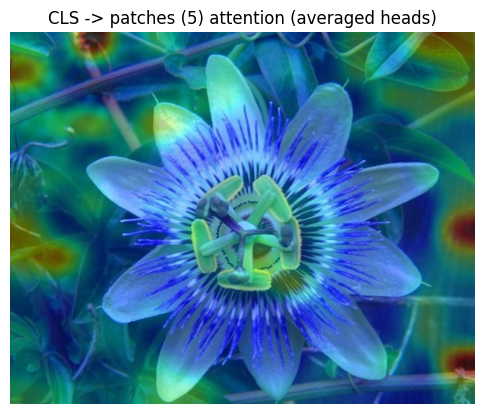

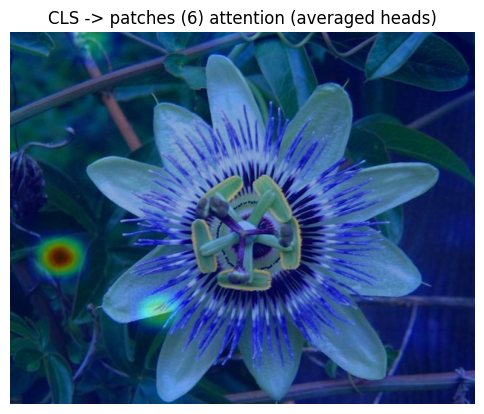

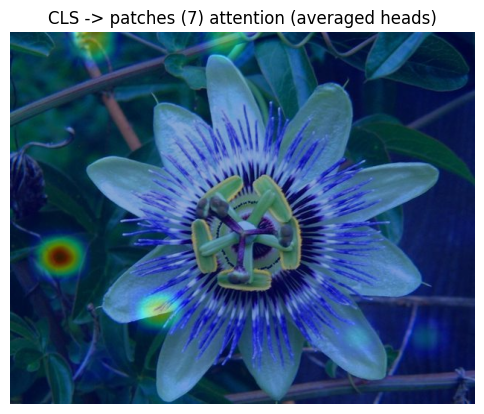

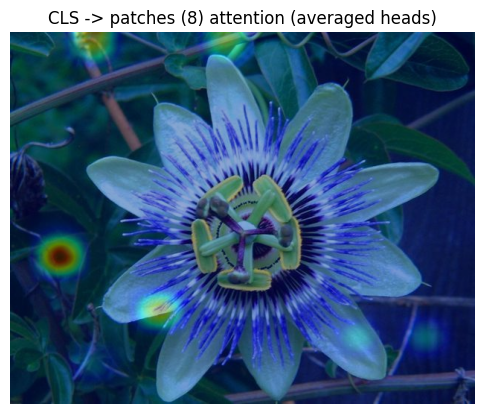

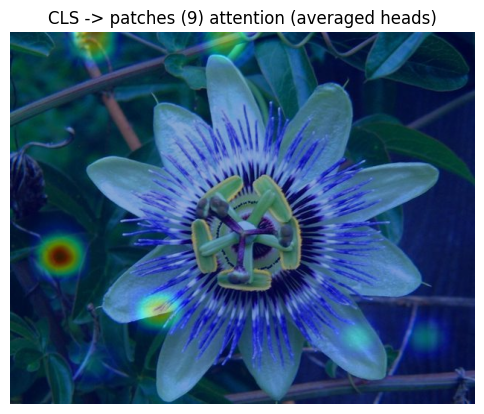

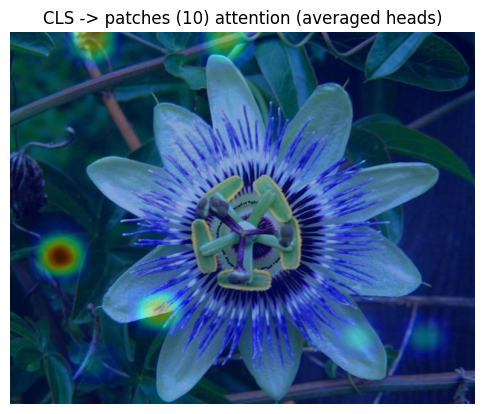

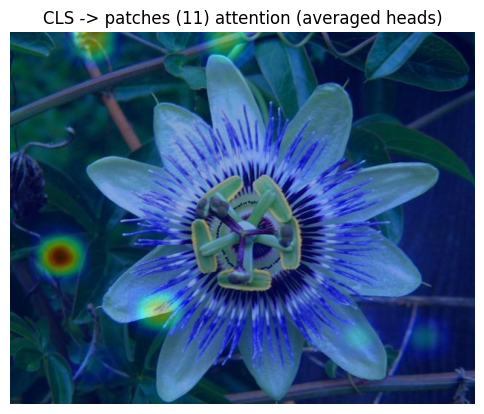

In [ ]:
import types
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
model.eval()

# prepare the image
img = Image.open("image_00002.jpg").convert("RGB")
img_t = preprocess(img).unsqueeze(0).to(device)

# --- Keep original forward so we can restore it later ---
orig_attn_forward = None

# --- Patched forward: bound method (self will be block.attn) ---
def patched_attn_forward(self, *args, **kwargs):
    # Ensure we ask for attention weights
    kwargs2 = dict(kwargs)
    kwargs2['need_weights'] = True
    out = orig_attn_forward(*args, **kwargs2)  # call original (bound) forward

    # orig may return (attn_output, attn_weights) or just attn_output
    if isinstance(out, (tuple, list)) and len(out) >= 2:
        attn_output, attn_weights = out[0], out[1]
        # save detached attention weights for later (on the attention module)
        # attn_weights shape often [batch, heads, seq_len, seq_len] but could vary
        self.attn_map = attn_weights.detach()
        return attn_output
    else:
        # Couldn't extract weights (implementation might not return them); just return the output.
        return out

# accessing specific tranformer block
num_blocks = len(model.visual.transformer.resblocks)

for i in range(num_blocks):
  # --- Keep original forward so we can restore it later ---
  block = model.visual.transformer.resblocks[i]  # last block
  orig_attn_forward = block.attn.forward

  # Bind patched forward to this attention module instance
  block.attn.forward = types.MethodType(patched_attn_forward, block.attn)

  # --- Run a forward pass to populate block.attn.attn_map ---
  with torch.no_grad():
      _ = model.encode_image(img_t)

  # --- Extract saved attention weights ---
  attn = getattr(block.attn, "attn_map", None)
  cls_to_patches = attn[:, 0, 1:]

  # reshape to grid and upsample to image size
  num_patches = cls_to_patches.shape[-1]
  grid = int(np.sqrt(num_patches))
  assert grid * grid == num_patches, f"expected square grid of patches, got {num_patches}"

  heat = cls_to_patches[0].cpu().numpy().reshape(grid, grid)
  heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)  # normalize

  # upscale to image size
  heat_img = Image.fromarray((heat * 255).astype(np.uint8)).resize(img.size, resample=Image.BICUBIC)
  heat_arr = np.array(heat_img) / 255.0

  # overlay
  plt.figure(figsize=(6,6))
  plt.imshow(img)
  plt.imshow(heat_arr, cmap="jet", alpha=0.35)
  plt.axis("off")
  plt.title(f"CLS -> patches ({i}) attention (averaged heads)")
  plt.show()

  # --- Restore original forward to avoid side effects ---
  block.attn.forward = orig_attn_forward

